In [2]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import chi2, mutual_info_classif, SelectKBest
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, learning_curve, StratifiedKFold
from pprint import pprint
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
import warnings
# Ignore all future warnings
import sklearn
warnings.simplefilter(action='ignore', category=FutureWarning)
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.3.1.


In [3]:
# Loading data into dataframes
def data_preprocessing(file_name):
    df = pd.read_csv(file_name)
    df.reset_index(drop=True)
    df = df.drop(df.columns[0], axis=1)
    return df

word_embed_train = data_preprocessing('384EMBEDDINGS_TRAIN.csv')
word_embed_test = data_preprocessing('384EMBEDDINGS_TEST.csv')
word_embed_validation = data_preprocessing('384EMBEDDINGS_VALIDATION.csv')

tfidf_train = data_preprocessing('TFIDF_TRAIN.csv')
tfidf_test = data_preprocessing('TFIDF_TEST.csv')
tfidf_validation = data_preprocessing('TFIDF_VALIDATION.csv')

train_data = data_preprocessing('TRAIN.csv')
test_data = data_preprocessing('TEST_NO_LABELS.csv')
validation_data = data_preprocessing('VALIDATION.csv')

In [4]:
# Setting up Train and Test dataset
y_train = train_data['rating'] # Train labels
y_vad = validation_data['rating'] # Validation labels
X_train = train_data.drop('rating', axis=1)
X_vad = validation_data.drop('rating', axis=1)

X_train_embed = word_embed_train # Train features for word embedding
X_vad_embed = word_embed_validation #Validate features

X_train_tf = tfidf_train # Train features for tfidf
X_vad_tf = tfidf_validation # Validate features

X_train_all = pd.concat([word_embed_train, tfidf_train],axis=1)
X_vad_all = pd.concat([word_embed_validation,tfidf_validation], axis=1)

In [5]:
all_column_names = X_train_all.columns
scaler = StandardScaler()
scaler.fit(X_train_all)
X_train_all_scaled = scaler.transform(X_train_all)
X_vad_all_scaled = scaler.transform(X_vad_all)
X_train_all_scaled = pd.DataFrame(X_train_all_scaled, columns=all_column_names)
X_vad_all_scaled = pd.DataFrame(X_vad_all_scaled, columns=all_column_names)

In [12]:
# Evaluation
# Get scores for the model
def get_scores(pred_label, true_label, average='macro'):
    # Accuracy
    accuracy = metrics.accuracy_score(true_label, pred_label)
    # Precision, Recall and F1-score (default: macro average)
    score_report = metrics.precision_recall_fscore_support(true_label, pred_label, average=average, zero_division=0) 
    # Confusion Matrix 
    confusion = metrics.confusion_matrix(true_label, pred_label)       
    return accuracy, score_report, confusion 

def plot_cm(plot_name,confusion):
    plt.figure(figsize=(4, 2))
    ax= plt.subplot()
    sns.heatmap(confusion, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted ratings');ax.set_ylabel('True ratings'); 
    ax.set_title(plot_name); 
    ax.xaxis.set_ticklabels(['Negative', 'Positive']); ax.yaxis.set_ticklabels(['Negative', 'Positive']);

def plot_learning_curve(plot_name, estimator, X_train, y_train, fold=5, scoring='f1_macro'):
    '''
    Stratified K-Folds cross-validator.

Provides train/test indices to split data in train/test sets.

This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.
    '''
    train_sizes, train_scores, valid_scores = learning_curve(estimator,X_train, 
                                                             y_train, scoring=scoring, cv=StratifiedKFold(fold),
                                                             train_sizes=np.linspace(0.1, 1.0, 5))
    print(f"Train scores: {np.round(np.mean(train_scores, axis=1),4)}")
    print(f"Validation scores: {np.round(np.mean(valid_scores, axis=1),4)}")
    plt.figure(figsize=(4, 3))
    plt.xlabel("training size")
    plt.ylabel("accuracy")
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color="r", label="Training score")
    plt.plot(train_sizes, np.mean(valid_scores, axis=1), 'o-', color="g", label="Cross-validation score")
    plt.ylim(0, 1.1)
    plt.yticks(np.arange(0,1.1,step=0.1))
    plt.grid(visible=True)
    plt.title(plot_name)
    plt.legend(loc="best")
    plt.show()

def display_performance(plot_name, pred_label, true_label):
    accuracy, scores, cm = get_scores(pred_label, true_label)
    print("Accuracy: ", round(accuracy,4))
    print("Precision: ", round(scores[0],4))
    print("Recall: ", round(scores[1],4))
    print("F1 : ", round(scores[2],4))
    plot_cm(plot_name, cm)

# Mismatched Reivew Examples
pd.set_option('display.max_colwidth', None)
def getMismatch(pred, sample_size):
    pred_df = pd.DataFrame(pred, columns=["prediction"])
    pred_df = pd.concat([validation_data, pred_df],axis=1)
    mismatched = pred_df.loc[pred_df["rating"] != pred_df["prediction"]]
    false_positive = mismatched.loc[mismatched["prediction"] == 1]
    false_negative = mismatched.loc[mismatched["prediction"] == -1]
    print("False Positive:")
    display(false_positive.head(sample_size))
    print("False Negative:")
    display(false_negative.head(sample_size))
    return false_positive, false_negative

In [9]:
##### Models Prior to Feature Engineering and Feature Selection #####

# KNN Model using Jaccard and cosine metric
def knn_model(X_train, X_vad, y_train, neighbours, metric='cosine', weights='distance'):
    estimator = KNeighborsClassifier(n_neighbors=neighbours, weights=weights,metric=metric)
    knn = estimator.fit(X_train, y_train)
    pred = knn.predict(X_vad)
    return pred, estimator

def find_k(max_k, X_train, y_train):
    # KNN - Finding K - the elbow method
    neighbours = list(range(1,max_k))

    knn_cosine_scores = []

    # Loop over each value of k
    for k in neighbours:
        knn_cosine = KNeighborsClassifier(n_neighbors=k, weights='distance', metric='cosine')
        
        # Use cross_val_score to get the F1 scores for each fold
        scores_cosine = cross_val_score(knn_cosine, X_train, y_train, cv=10, scoring='accuracy')
        score = round(scores_cosine.mean(),4)
        # Append the mean F1 score for the current k to the cv_scores list
        print(f'{k} neighbours: {score}')
        knn_cosine_scores.append(scores_cosine.mean())
              
    # Determine the best k (the one with the highest F1 score)
    optimal_k = neighbours[knn_cosine_scores.index(max(knn_cosine_scores))]
    return optimal_k, neighbours, knn_cosine_scores


def plot_k_elbow(optimal_k, neighbours, knn_cosine_scores):
    print(f"The optimal number of neighbors is {optimal_k}")
    # Plot Accuracy score vs k
    plt.figure(figsize=(8, 4))
    plt.plot(neighbours, knn_cosine_scores, marker='o', linestyle='-', color='b')
    plt.xlabel('K')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. K')
    plt.show()

# Feature Selection
def select_features(estimator, X_train, y_train, score_func, min_num, max_num, fold=5, scoring='f1_macro'):
    best_num_features = 0
    best_features_indices = []
    best_features = []
    best_score = -1

    # Iterate over different numbers of features
    for k in range(min_num, max_num):
        selector = SelectKBest(score_func=score_func, k=k)
        X_new = selector.fit_transform(X_train, y_train)
        
        # Evaluate with cross-validation
        score = cross_val_score(estimator, X_new, y_train, scoring=scoring, cv=StratifiedKFold(fold)).mean()
        
        if score > best_score:
            best_score = score
            best_num_features = k
            best_features_indices = selector.get_support(indices=True)
    
    best_features = X_train.columns[best_features_indices].tolist()
    X_train_new = X_train[best_features]
    print(f"Best number of features {best_num_features} scoring {round(best_score,4)}")

    return best_num_features, X_train_new, best_score

def knn_run(plot_name, X_train, X_vad, y_train, y_vad, neighbours, metric='euclidean', weights='distance'):

    pred, estimator = knn_model(X_train, X_vad, y_train, neighbours=neighbours, metric=metric, weights=weights)

    plot_learning_curve(plot_name,estimator, X_train, y_train)

    display_performance(plot_name,pred, y_vad)
    return pred

# Mismatched Reivew Examples
pd.set_option('display.max_colwidth', None)
def getMismatch(pred, sample_size):
    pred_df = pd.DataFrame(pred, columns=["prediction"])
    pred_df = pd.concat([validation_data, pred_df],axis=1)
    mismatched = pred_df.loc[pred_df["rating"] != pred_df["prediction"]]
    false_positive = mismatched.loc[mismatched["prediction"] == 1]
    false_negative = mismatched.loc[mismatched["prediction"] == -1]
    print("False Positive:")
    display(false_positive.head(sample_size))
    print("False Negative:")
    display(false_negative.head(sample_size))
    return false_positive, false_negative


## KNN Base - Model Performance

In [8]:
# Default parameter set_up
default_k = math.floor(math.sqrt(len(X_train_embed)))
default_k = default_k if default_k % 2 != 0 else default_k + 1

knn_embed_plot_name = "KNN - Word Embeddings"
knn_tf_plot_name = "KNN - TFIDF"
knn_all_plot_name = "KNN - Both features"

_Base KNN - Word Embeddings_

Base KNN - Word Embeddings with 207 neighbours
Train scores: [0.9872 0.9847 0.9842 0.9842 0.9842]
Validation scores: [0.7276 0.7949 0.8083 0.814  0.822 ]


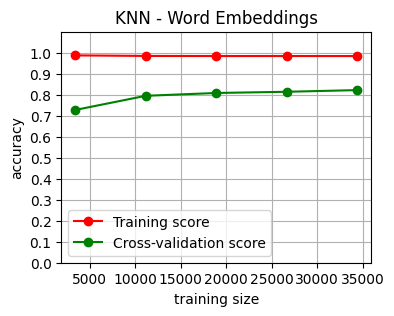

Accuracy:  0.878
Precision:  0.8819
Recall:  0.7954
F1 :  0.8254


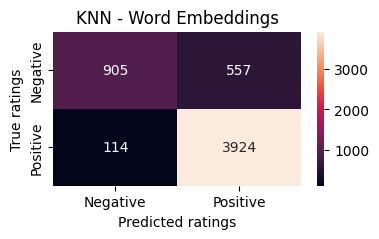

In [30]:
# using cosine as it's text data, cosine is considere more appropriate
# KNN with word embedding has higher training score suggesting the model has less bias than KNN with TFIDF. The validation score also 

print(f"Base KNN - Word Embeddings with {default_k} neighbours")
knn_run(knn_embed_plot_name, X_train_embed, X_vad_embed, y_train, y_vad, neighbours=default_k, metric='cosine', weights='distance')

_Base KNN - TF-IDF_

Base KNN - TFIDF with 207 neighbours
Train scores: [0.9752 0.9722 0.9717 0.9722 0.9721]
Validation scores: [0.6163 0.7044 0.7258 0.737  0.7488]


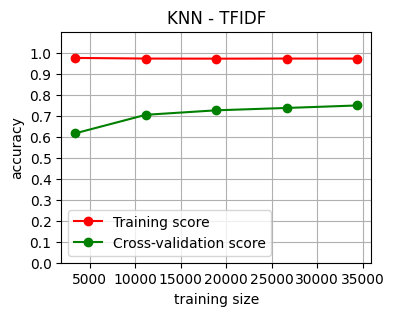

Accuracy:  0.8404
Precision:  0.8487
Recall:  0.7244
F1 :  0.7565


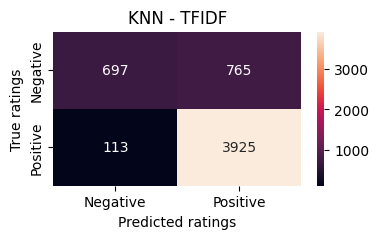

In [15]:
print(f"Base KNN - TFIDF with {default_k} neighbours")
knn_run(knn_tf_plot_name, X_train_tf, X_vad_tf, y_train, y_vad, neighbours=default_k, metric='cosine', weights='distance')

_Base KNN - Both features_

Base KNN - Both features with 207 neighbours
Train scores: [0.9872 0.9847 0.9842 0.9842 0.9842]
Validation scores: [0.8391 0.8415 0.8439 0.8417 0.8434]


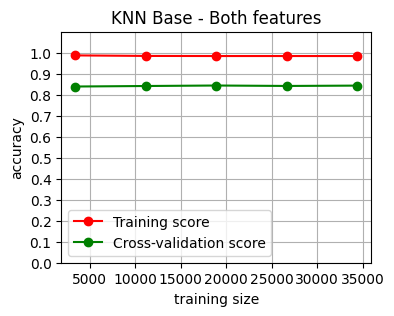

Accuracy:  0.8798
Precision:  0.8677
Recall:  0.8126
F1 :  0.8343


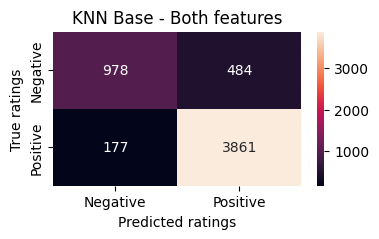

In [18]:
print(f"Base KNN - Both features with {default_k} neighbours")
knn_both_pred = knn_run("KNN Base - Both features", X_train_all_scaled, X_vad_all_scaled, y_train, y_vad, neighbours=default_k, metric='cosine', weights='distance')

In [13]:
print("KNN Base - Both features")
knn_both_base_pred_FP, knn_both_base_pred_FN = getMismatch(knn_both_pred, 10)

KNN Base - Both features
False Positive:


,dr-id-adjusted,dr_id_gender,review-text-cleaned,rating,prediction
34,33662,1.0,,-1,1
39,33689,0.0,"Staff leaves a lot to be desired and if you have to deal with crap before you get to the a decent doctor, it ain't worth my time.",-1,1
60,33748,1.0,"This doctor is a joke! He misdiagnosed me for a very serious ailment, stated I had MS. On top of if all the office is filthy.",-1,1
78,33785,1.0,The physician screwed up my root canal by missing a fourth root on the x-ray (!) and then I had to have it redone. Cost me a ton of extra money and pain.,-1,1
79,33785,1.0,"Did not have a good experience, problems with billing and would not return my phone calls and discuss the problem. Changed dentists, and much happier.",-1,1
115,33888,1.0,Very judgemental.Doesn't listen to patients. Assumes the worst of people. Doesn't understand treating patients versus treating a number/chart/diagnosis.,-1,1
155,33971,1.0,"Put patient back on walking without taking xrays, there was a broken screw and the leg was still broken, had to have surgery all over again, by a different surgeon of course.",-1,1
165,33981,0.0,"Puts people on diabetic drugs when the A1C is only 7.5, and Januvia is known to cause pancreatitis.",-1,1
167,33981,0.0,Very judgemental and does not take into account that different people deal with pain differently.,-1,1
169,33999,1.0,I have been seeing Dr. Fahrendorf for years. He always seems to help me with my back problems. He really is a great chiropractor,-1,1


False Negative:


,dr-id-adjusted,dr_id_gender,review-text-cleaned,rating,prediction
15,33654,0.0,"I went to Dr Wadud as a new patient in June 2012. Dr Wadud did blood tests on me and suspected from my test results that I had hyperparathyroidism. After sending me for more blood tests, it was confirmed. I had had this disease for many years and previous doctors had missed it over and over again. I have since gone to Dr Norman in Tampa Fl for surgery and am cured. I will be forever grateful to Dr Wadud for her thoroughness &amp; exceptional knowledge.",1,-1
25,33659,1.0,"From the minute I walked in the office, I was treated with respect and kindness. Dr Walker does work at a faster pace than most other doctors I have been to, but he is very knowledgeable and helpful. You could not ask for a better doctor.",1,-1
36,33678,1.0,"Doesn't have an on call Dr. number. I was in pain and just wanted to speak to a dentist that knew me, and let them know what was going on. I had to go to an urgent care to get antibiotics sbd pain meds that didn't work.",1,-1
57,33746,2.0,,1,-1
95,33863,1.0,"Dr Akerson was great. Appeared knowledgeable, willing to sit and explain, and the result was as promised. His staff was terrible. Rude, insulting, arrogant. I'm honestly not certain going to him is worth putting up with them.",1,-1
102,33871,1.0,"While I also believe that Dr. Allard is a wonderful doctor, I do not appreciate that I always have to call him for my lab results. (They have never called me with the results-I always seem to get forgotten). I would guess that this is because he has too large of a patient load. Each time I need to have him evaluate my lab results, I have to call the clinic in order to get the information needed. Not good customer service. :-(",1,-1
114,33888,1.0,"I can't understand the last post....REALLY&#63;&#63; I agree more with the others. He does take TIME and was very concerned about me - not just the refill I needed but preventative care and how I have been doing with some other issues... His office provides appointment reminders, and always call my tests results back the next day! His staff are as personable and caring as any office I have ever been in. This is a great doctor !",1,-1
116,33888,1.0,I feel Dr Diamond was very knowlegable and aggressive with his care. My daughter has a very hard time breathing asthema this Dr was the only one out of 5 that got it right. He is prompt very kid friendly. We were an inch from going to Denver Jewish hospital. He gave us his cell phone number and asked us to call anytime we need him. Anytime. We were on a trip and called back home and he called the prescription into a pharmacy on our trip my child was miserable without the medicine. He sits with me and will explain the problem. I would recommend Dr Diamond to anyone who want's a Dr that care's. I my self and daughters go here and will continue to. Friendly staff in the office too. You only wait 10 minutes before being seen.,1,-1
128,33891,1.0,"I agree with all the other comments, we to have gone to him for years and have had nothing but excellent treatment. Before going to Dr Dehaan I really didnt care do Dr visits and now I look forward to seeing him. Recently I was hospitalized for a reather severe infection and was admitted through the ER unfortunatly he was not on cal at the time and I was admitted by one of his other partners (who did a great job also). Several days went by and Dr Dehaan stopped in to check on me on a tuesday morn, it was a great visit. I told my wife who works in the medical field that he had stopped by on the tuesday morning, and she had told that was his day off! What a great guy, caring, compassionate and very deicated to his patients. I will recommend no other GP.",1,-1
134,33896,0.0,"A. Front desk receptionist unknowledgable and flighty but they changed that. Sitting with sick child in room for an hour and forgot us. No communication between nurses, staff and patients. They made me feel like a bad mom because I chose t

# Feature Selection

In [9]:
def feature_searcher(estimator, X_train, y_train, param_grid, percentiles, fold=5):
    # Initialize variables to store the best score and corresponding best features and parameters
    best_score = 0
    best_features = None
    best_params = None
    best_perc = None

    total_iterations = len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(percentiles)  # 31 percentiles from 50 to 80
    # Iterate over all possible combinations of parameters for RandomForestClassifier
    with tqdm(total=total_iterations) as pbar:
        for params in ParameterGrid(param_grid):
            rf = RandomForestClassifier(**params, criterion='entropy',random_state=0)
            rf.fit(X_train, y_train)
            
            # Get feature importances and select features based on the provided percentile
            importances = rf.feature_importances_

            for p in percentiles:
                perc = np.percentile(importances, p)
                selected_features_name = X_train.columns[importances >= perc]
                X_train_selected = X_train[selected_features_name].copy()
            
            
                scores = cross_val_score(estimator, X_train_selected, y_train, cv=StratifiedKFold(fold), scoring='f1_macro')  

                avg_score = np.mean(scores)
                pbar.update(1)
                # Update the best score, features, and parameters if the current score is better than the best score
                if avg_score > best_score:
                    best_score = avg_score
                    best_features = selected_features_name
                    best_params = params
                    best_perc = p

        print(f"Best Score: {best_score}")
        print(f"Best Features: {list(best_features)}")
        print(f"Best Percentile: {best_perc}")
        print(f"Best RandomForest Parameters: {best_params}")
    return best_features, best_score, best_perc, best_params     

In [26]:
knn_both_estimator = KNeighborsClassifier(n_neighbors=51, metric='euclidean', weights='distance')

param_grid = {
    'n_estimators': [200, 300, 400, 500],
    'max_depth': [10, 15, 20],
}
percentiles = list(range(50,91,5)) 

In [25]:
best_features_all, best_score_all, best_perc_all, best_params_all = feature_searcher(knn_both_estimator, X_train_all_scaled, y_train, param_grid, percentiles=percentiles)

100%|██████████| 96/96 [1:29:12<00:00, 55.76s/it] 

Best Score: 0.8801144216889771
Best Features: ['0', '1', '4', '5', '10', '19', '20', '22', '34', '35', '40', '45', '54', '55', '56', '57', '59', '61', '62', '65', '69', '70', '71', '78', '80', '88', '90', '91', '92', '102', '104', '108', '113', '118', '121', '123', '126', '127', '128', '130', '131', '132', '134', '136', '137', '138', '139', '142', '144', '146', '150', '152', '154', '157', '160', '161', '164', '165', '166', '174', '175', '177', '178', '179', '180', '196', '200', '207', '209', '212', '220', '224', '227', '230', '235', '238', '242', '245', '247', '251', '257', '259', '261', '263', '265', '271', '272', '276', '277', '278', '280', '284', '285', '286', '287', '292', '297', '301', '302', '303', '306', '309', '316', '317', '319', '322', '330', '334', '336', '337', '340', '342', '345', '346', '347', '348', '351', '354', '357', '359', '366', '369', '372', '378', 'best', 'caring', 'dr', 'excellent', 'great', 'knowledgeable', 'rude', 'told', 'worst']
Best Percentile: 85
Best Rando

In [14]:
best_features_all = ['0', '1', '4', '5', '10', '19', '20', '22', '34', '35', '40', '45', '54', '55', '56', '57', '59', '61', '62', '65', '69', '70', '71', '78', '80', '88', '90', '91', '92', '102', '104', '108', '113', '118', '121', '123', '126', '127', '128', '130', '131', '132', '134', '136', '137', '138', '139', '142', '144', '146', '150', '152', '154', '157', '160', '161', '164', '165', '166', '174', '175', '177', '178', '179', '180', '196', '200', '207', '209', '212', '220', '224', '227', '230', '235', '238', '242', '245', '247', '251', '257', '259', '261', '263', '265', '271', '272', '276', '277', '278', '280', '284', '285', '286', '287', '292', '297', '301', '302', '303', '306', '309', '316', '317', '319', '322', '330', '334', '336', '337', '340', '342', '345', '346', '347', '348', '351', '354', '357', '359', '366', '369', '372', '378', 'best', 'caring', 'dr', 'excellent', 'great', 'knowledgeable', 'rude', 'told', 'worst']


## Hyperparameter Tuning

In [17]:
def knn_pipeline(X_train, y_train, k=default_k, fold=5, scoring='f1_macro', verbose=1):
    search_space = [{'classifier': [KNeighborsClassifier()],
                    'classifier__n_neighbors': list(range(1,k,2)),
                    'classifier__metric': ['euclidean', 'cosine']}]
    p1 = Pipeline([('classifier', KNeighborsClassifier())])
    gs = GridSearchCV(p1, search_space, cv=StratifiedKFold(fold), scoring=scoring, verbose=verbose)
    result = gs.fit(X_train,y_train)
    return result

In [18]:
knn_all = knn_pipeline(X_train_all_scaled[best_features_all], y_train, k=51)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


KNN - Both features - best parameter
Best parameters
{'classifier': KNeighborsClassifier(metric='euclidean', n_neighbors=19), 'classifier__metric': 'euclidean', 'classifier__n_neighbors': 19}
Best score
0.880133543045648


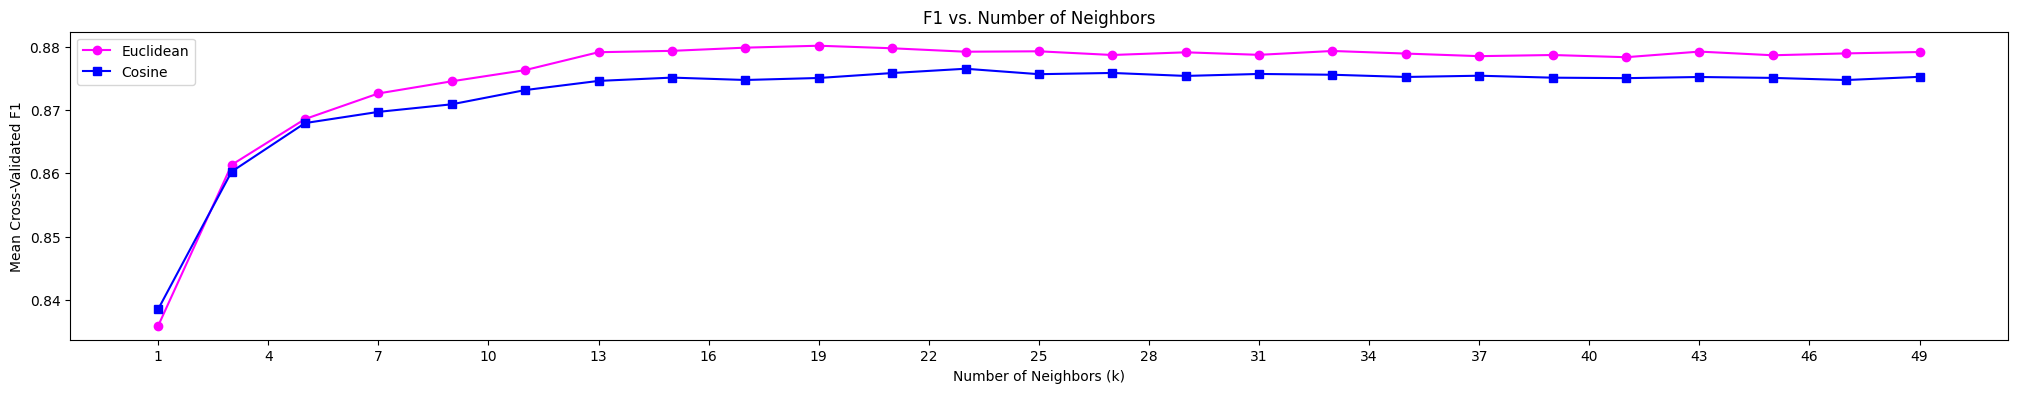

In [19]:
print("KNN - Both features - best parameter")
print("Best parameters")
print(knn_all.best_params_)
print("Best score")
print(knn_all.best_score_)

# Extract the mean test scores for each parameter
all_mean_f1 = knn_all.cv_results_['mean_test_score']
all_params = knn_all.cv_results_['params']

# Extract the corresponding k values
k_values = list(range(1, 51, 2))

# Separate the scores based on the metric
all_euclidean_scores = [score for score, param in zip(all_mean_f1, all_params) if param['classifier__metric'] == 'euclidean']
all_cosine_scores = [score for score, param in zip(all_mean_f1, all_params) if param['classifier__metric'] == 'cosine']

plt.figure(figsize=(25, 4))

# Plot Euclidean scores in pink/purple
plt.plot(k_values, all_euclidean_scores, marker='o', color='magenta', label='Euclidean') 

# Plot Cosine scores in blue
plt.plot(k_values, all_cosine_scores, marker='s', color='blue', label='Cosine')

plt.xlabel('Number of Neighbors (k)')
plt.xticks(range(min(k_values), max(k_values) + 1, 3))  # Change 5 to your 
plt.ylabel('Mean Cross-Validated F1')
plt.title('F1 vs. Number of Neighbors')
plt.legend(loc='best')
plt.show()

Train scores: [0.9872 0.9846 0.9834 0.9835 0.9832]
Validation scores: [0.8532 0.8734 0.8767 0.8779 0.8804]


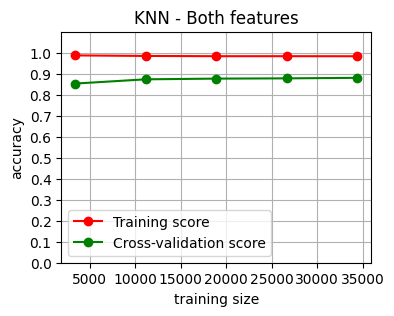

Accuracy:  0.9033
Precision:  0.8814
Recall:  0.8669
F1 :  0.8737


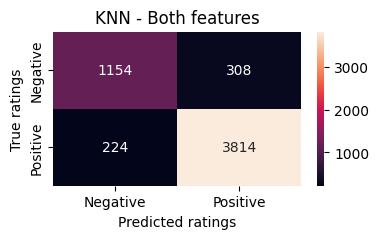

In [19]:
# Post hypermarameter turning
knn_both_post_pred, knn_both_post_estimator = knn_model(X_train_all_scaled[best_features_all], X_vad_all_scaled[best_features_all], y_train, neighbours=19, metric='euclidean', weights='distance')
plot_learning_curve("KNN - Both features",knn_both_post_estimator, X_train_all_scaled[best_features_all],y_train)
display_performance("KNN - Both features",knn_both_post_pred, y_vad)

In [17]:
print("KNN post tuning and feature selection - Both features")
knn_both_pred_post_FP, knn_both_pred_post_FN = getMismatch(knn_both_post_pred, 10)

KNN post tuning and feature selection - Both features
False Positive:


,dr-id-adjusted,dr_id_gender,review-text-cleaned,rating,prediction
21,33659,1.0,"Both of the times I've been to him, he gives medication in a 5-10 minute period, doesn't really examine, and then leaves without telling you what you have! He actually leaves to write the prescription, and a nurse brings it in. It has left me going hunh&#63;",-1,1
34,33662,1.0,,-1,1
44,33708,1.0,Each time (4 visits) I waited about hour or more over the scheduled appt. time. Did not take my concern about med. side effects very seriously. I did not feel he was listening very well as he said &quot;What&quot; very often and was very loud.,-1,1
61,33749,1.0,He advised me I needed a pace maker. Two weeks later his associate stated I did not need the pace maker. I had reservations about him from the moment I met him.,-1,1
70,33763,0.0,". would not recommend this doctor, trained in eastern europe, has careless attitude, does not communicate well",-1,1
79,33785,1.0,"Did not have a good experience, problems with billing and would not return my phone calls and discuss the problem. Changed dentists, and much happier.",-1,1
96,33863,1.0,"Liked Dr. Akerson but office staff/personnel were patronizing, rude, arrogant, and hard to deal with. Terrible experience. Will go elsewhere, even if I have to pay more.",-1,1
167,33981,0.0,Very judgemental and does not take into account that different people deal with pain differently.,-1,1
169,33999,1.0,I have been seeing Dr. Fahrendorf for years. He always seems to help me with my back problems. He really is a great chiropractor,-1,1
184,34010,0.0,"I did not get the impression that Ms. Folkens has the empathy, knowledge, experience or skills to treat me or others well. I would not recommend her to my friends or family as a neurology provider. The office staff (ie nurses, receptionists) are, however, great.",-1,1


False Negative:


,dr-id-adjusted,dr_id_gender,review-text-cleaned,rating,prediction
17,33659,1.0,The absolute rudest front desk staff I have ever encountered. Once you get back to see the doctor it is fine but the office staff makes you really want to find another doctor.,1,-1
36,33678,1.0,"Doesn't have an on call Dr. number. I was in pain and just wanted to speak to a dentist that knew me, and let them know what was going on. I had to go to an urgent care to get antibiotics sbd pain meds that didn't work.",1,-1
57,33746,2.0,,1,-1
102,33871,1.0,"While I also believe that Dr. Allard is a wonderful doctor, I do not appreciate that I always have to call him for my lab results. (They have never called me with the results-I always seem to get forgotten). I would guess that this is because he has too large of a patient load. Each time I need to have him evaluate my lab results, I have to call the clinic in order to get the information needed. Not good customer service. :-(",1,-1
134,33896,0.0,"A. Front desk receptionist unknowledgable and flighty but they changed that. Sitting with sick child in room for an hour and forgot us. No communication between nurses, staff and patients. They made me feel like a bad mom because I chose to leave and take my child home after waiting an hour and a half.",1,-1
150,33935,1.0,"Too many red flags went up when I saw him ,When my Dr was too busy.",1,-1
172,34004,0.0,"Very helpful, kind and understanding. She has never been rude - I bring 6 children to her and she is always wonderful. Her staff is not great - but I put up with them in order to see her.",1,-1
181,34007,0.0,"She ordered tests, they were performed immediately and she was on the phone to me within 2 hours to let me know I did not have a tumor on the brain. She recommended another dr to do follow up. I went and found out rapidly what was wrong with me. Dr. Florio is a fine Dr. She can be abrupt but she helped me so much when many other doctors could not.",1,-1
220,34073,1.0,,1,-1
228,34079,1.0,"I had a surgery done with Dr. Peery and had a ton of complications. Dr. Peery had refused to see or treat me thinking I had nothing wrong with me. On my last attempt to correct my problems, Dr. Glatt had decided he wanted to look at me and my situation. He first asked me what I thought was wrong, and how I was feeling before he even started going into the possible complications I could be having. He was very respectful, listened carefully, and took his time. Within two weeks Dr. Glatt had not only found out what was wrong with me, but had it fixed, where as Dr. Peery wouldn't even give me the time of day. Dr. Glatt gets a 150% rating from me, because not only did he help me, but he cared for me. Kudos to Dr. Glatt for being the kind of doctor that not many are anymore.",1,-1
